# Core Values - Helper Notebook

This challenge provides a substantial dataset consisting of high-resolution photos of sedimentary core samples. Each image contains various facies (layers) that need to be classified. Most of the data is unlabeled, making it an excellent opportunity to leverage unsupervised learning techniques.

### Background on Computer Vision Techniques
Computer vision techniques have become increasingly powerful in recent years, enabling machines to understand and process visual information with unprecedented accuracy. For this challenge, you could focus on using deep learning models, specifically convolutional neural networks (CNNs) and segmentation models like U-Net or Mask R-CNN.

### Convolutional Neural Networks (CNNs)
CNNs are particularly well-suited for image classification tasks, but they can also be adapted for image segmentation. The architecture typically includes convolutional layers to extract features from the input images, followed by pooling layers to reduce spatial dimensions, and fully connected layers to make predictions.

### U-Net
U-Net is a popular choice for image segmentation due to its symmetric design. It consists of an encoder (contracting path) that captures multi-scale context and a decoder (expanding path) that maps the high-level features back to the original spatial dimensions. Skip connections between corresponding layers in the encoder and decoder allow information to flow from higher to lower levels, facilitating precise segmentation.

### Mask R-CNN
Mask R-CNN builds upon Faster R-CNN by adding a branch for predicting instance masks during object detection. This makes it well-suited for tasks where both bounding boxes and segmentation masks are needed. It includes several key components:

- Region Proposal Network (RPN): Detects potential regions of interest in the image.
- Feature Pyramid Network (FPN): Captures multi-scale features from the input image.
- Box Predictor: Refines proposals into bounding boxes and predicts class labels.
- Mask Head: Predicts segmentation masks for each detected object.

### Approach to Building a Model
1. Data Preparation:
- Load and preprocess the high-resolution images, resizing them to a uniform size if necessary.
- Create ground truth annotations (segmentation masks) for labeled images if available.

2. Model Selection:
- Choose a pre-trained CNN architecture or build a custom model using PyTorch.
- You could consider using U-Net or Mask R-CNN due to their effectiveness in image tasks.

3. Training the Model:
- Fine-tune the model on labeled data if available, adjusting hyperparameters as needed.
- Use techniques like data augmentation to increase the diversity of your training set and improve generalization.

4. Evaluation Metrics:
- Evaluate the model's performance using metrics such as Intersection over Union (IoU), Dice Coefficient, and Precision-Recall curves.
- Monitor validation performance to ensure that the model is not overfitting.

5. Post-processing:
- Apply thresholding or other post-processing techniques to refine segmentation masks.
- Evaluate the final model on the test set to obtain an unbiased estimate of its performance.

For now, you are going to investigate how to use the Segment Anything Model to get patch embeddings and see how the embeddings cluster. To get started you need the following packages in the next cell

In [1]:
# ! pip install opencv-python matplotlib onnxruntime scikit-learn seaborn && pip install git+https://github.com/facebookresearch/segment-anything.git

### Step 1: Import Necessary Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, os, random
import seaborn as sns, warnings
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
warnings.filterwarnings("ignore")
sns.set_style('dark')

### Step 2: Load and Preprocess Example Image

Download the labeled and unlabeled images from the `Data Tab` after [joining the Challenge](https://thinkonward.com/app/c/challenges/core-values)

In [3]:
example_image = cv2.imread("train_unlabeled/image001432.png")

### Step 3: Initialize the SAM Model

The Segment Anything Model (SAM) is initialized with a pre-trained checkpoint. The model type can be 'vit_b' or 'vit_l' and you must download the [model checkpoints from GitHub](https://github.com/facebookresearch/segment-anything?tab=readme-ov-file#model-checkpoints) before you get started.

In [4]:
model_type = "vit_b"  # You can choose 'vit_b' or 'vit_l'
sam_checkpoint = "sam_vit_b_01ec64.pth" # Make sure this path points to the checkpoint, wherever you saved it
model = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
predictor = SamPredictor(model)

### Step 4: Perform Inference to Get Mask Output

Use the SAM model to generate masks for the example image and visualize them.

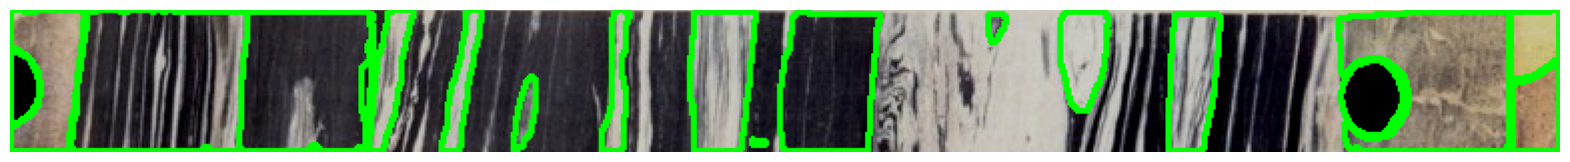

In [5]:
mask_generator = SamAutomaticMaskGenerator(model)
masks = mask_generator.generate(example_image)

def visualize_mask(image, masks):
    for mask in masks:
        binary_mask = (mask['segmentation'] * 255).astype(np.uint8)
        contour, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(image, contour, -1, (0, 255, 0), 2)

visualize_mask(example_image, masks)

rotated_image = cv2.rotate(example_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.figure(figsize=(20, 8))  
plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### Step 5: Extract Patch Embeddings from All Images
Iterate through all images in the `train_unlabeled` directory and extract patch embeddings using the SAM model.

In [ ]:
# This takes a while to run on CPU, you can run on GPU if available

image_dir = "train_unlabeled"
all_embeddings = []

def extract_patch_embeddings(image, predictor):
    patch_embeddings = predictor.features
    return patch_embeddings

for filename in tqdm(os.listdir(image_dir)):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_dir, filename)
        example_image = cv2.imread(image_path)
        predictor.set_image(example_image)
        embeddings = extract_patch_embeddings(example_image, predictor)
        all_embeddings.append(embeddings)

all_embeddings_flat = np.concatenate(all_embeddings, axis=0)
all_embeddings_reshaped = all_embeddings_flat.reshape(-1, all_embeddings_flat.shape[-1])

scaler = StandardScaler()
all_embeddings_normalized = scaler.fit_transform(all_embeddings_reshaped)
np.save('all_embeddings_normalized.npy', all_embeddings_normalized)

### Step 6: Load Normalized Embeddings and Perform Dimensionality Reduction
Load the normalized embeddings and reduce their dimensionality using t-SNE for visualization.

In [6]:
all_embeddings_normalized = np.load('all_embeddings_normalized.npy')
# Reduce the number of samples for faster computation
n_samples = 75_000
sample_indices = np.random.choice(all_embeddings_normalized.shape[0], n_samples, replace=False)
sampled_embeddings = all_embeddings_normalized[sample_indices]

tsne = TSNE(n_components=2, max_iter=500, random_state=42, perplexity=50, learning_rate=500)
tsne_result = tsne.fit_transform(sampled_embeddings)

### Step 7: Apply Gaussian Mixture Modeling (GMM) clustering to the reduced data and visualize the clusters.

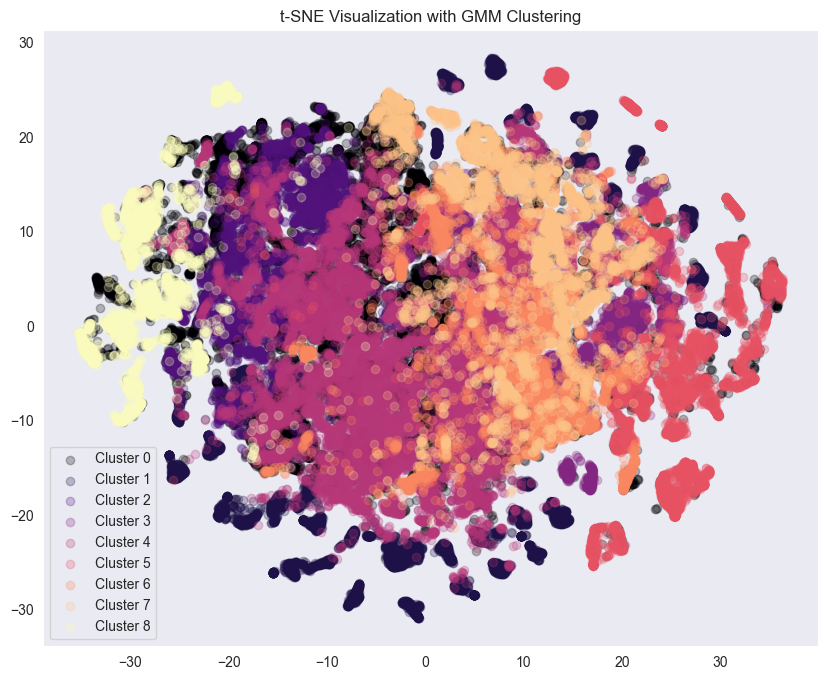

In [7]:
gmm = GaussianMixture(n_components=9, init_params='random_from_data')
cluster_labels = gmm.fit_predict(sampled_embeddings)

plt.figure(figsize=(10, 8))
colors = plt.cm.magma(np.linspace(0, 1, len(set(cluster_labels))))

for i in range(gmm.n_components):
    cluster_points = tsne_result[cluster_labels == i]
    if len(cluster_points) > 0:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colors[i]], label=f'Cluster {i}', alpha=0.25)
plt.title("t-SNE Visualization with GMM Clustering")
plt.legend()
plt.show()

### Next Steps:

1. Improve the clustering and visually inspect which facies types are in each cluster
2. Improve dimensionality reduction
3. Leverage labeled data to make predictions based on clusters
4. Something else? We know you can figure out something amazing!